# Proyecto 03 - Sistemas de Recomendación

## Dataset: STEAM

**Recuerda descargar el dataset de [aquí](https://github.com/kang205/SASRec). Son dos archivos, uno de calificaciones y otro de información sobre los juegos.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset. Sin embargo, **deberás** modificarlas para hacer un mejor manejo de datos. Algunas cosas a las que deberás prestar atención (tal vez no a todas):
1. Tipos de datos: elige tipos de datos apropiados para cada columna.
2. Descartar columnas poco informativas.
3. Guardar en memoria datasets preprocesados para no tener que repetir código que tarde en correr.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿cuáles son los juegos más populares?¿Y los menos populares?

### Filtro Colaborativo

Deberás implementar un sistema de recomendación colaborativo para este dataset. Ten en cuenta:

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada sus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo.

Puedes implementar un filtro colaborativo a partir de la similitud coseno o índice de Jaccard. ¿Puedes utilizar los métodos de la librería Surprise? Si no es así, busca implementaciones (por ejemplo, nuevas librerías) que sean apropiadas.

Para comenzar a trabajar, puedes asumir que cada entrada es un enlace entre una persona usuaria y un item, **independientemente** de si la crítica es buena o mala. 

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo harías para ponerle un valor a la calificación?
1. ¿Cómo harías para agregar contenido? Por ejemplo, cuentas con el género, precio, fecha de lanzamiento y más información de los juegos.
1. ¿Hay algo que te gustaría investigar o probar?

### 1. CONVERTIMOS ARCHIVOS JSON A CSV

In [1]:
#import gzip
#import pandas as pd

#def parse(path):
#    g = gzip.open(path, 'r')
#    for l in g:
#        yield eval(l)

#### 1.1 REVIEWS

In [2]:
#contador = 0
#data_reviews = []
# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n = 3, 
# abrira uno de cada tres, y asi.
#n = 10
#for l in parse('steam_reviews.json.gz'):
#    if contador%n == 0:
#        data_reviews.append(l)
#    else:
#        pass
#    contador += 1

In [3]:
#data_reviews = pd.DataFrame(data_reviews)

In [4]:
#data_reviews.head()

In [5]:
#data_reviews.to_csv('new_data_reviews.csv')

#### 1.2 GAMES

In [6]:
#data_games = []
#for l in parse('steam_games.json.gz'):
#    data_games.append(l)
#data_games = pd.DataFrame(data_games)

In [7]:
#data_games.head()

In [8]:
#data_games.to_csv('new_data_games.csv')

### 2. BREVE DESCRIPCIÓN DE STEAM

__Steam__ es un sistema de distribución de juegos multiplataforma en línea, con alrededor de 75 millones de usuarios activos, alrededor de 172 millones de cuentas en total, que aloja más de 3000 juegos, lo que lo convierte en una plataforma ideal para el tipo de trabajo que aquí se presenta. El conjunto de datos contiene registros de más de 3200 juegos y aplicaciones.  

Steam es un servicio de distribución digital de videojuegos de Valve. Se lanzó como un cliente de software independiente en septiembre de 2003 como una forma de que Valve proporcionara actualizaciones automáticas para sus juegos y luego, se expandió para incluir juegos de editores externos. Steam también se ha expandido a una tienda digital móvil y basada en la web en línea.  

De acuerdo con la **popularidad del juego, la similitud de la descripción del juego, la calidad del juego y la preferencia del jugador por el juego**, recomiendan el juego correspondiente al jugador del juego, de modo que Steam obtenga un mayor grado de satisfacción del cliente.

### 3. ANÁLISIS EXPLORATORIO DE DATOS

1. __Se importan las librerías__ necesarias para trabajar en la consigna.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd

import gc # garbage collector

from surprise import Dataset # convertimos nuestro Dataframe en Dataset
                             # es la estructura de datos que utiliza Surprise!, para almacenar la Matriz de Utilidad
                             # es la forma de almacenar datos con menos memoria, ya que la Matriz de Utilidad es muy grande     
from surprise import Reader # lector de Surprise!
from surprise.model_selection import train_test_split
# quita calificacione de usuario-película de forma aleatoria s/ toda la matriz de utilidad, teniendo cuidado de no quitarle..
# ..todas las calificaciones a un usuario ni a una película

2. __Se realiza la carga el dataset__ usando las funcionalidades de Pandas.

__DATA REVIEW__

In [10]:
new_data_reviews = pd.read_csv('new_data_reviews.csv')

In [11]:
new_data_reviews.shape # Filas y columnas

(779307, 13)

* *El Dataset, cuenta con **779.307 Filas**, y **13 Columnas**.*

In [12]:
new_data_reviews.head(3) # Primeras 3 instancias (filas)

,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN


__DATA GAMES__

In [13]:
new_data_games = pd.read_csv('new_data_games.csv')

In [14]:
new_data_games.shape # Filas y columnas

(32135, 17)

* *El Dataset, cuenta con **32.135 Filas**, y **13 Columnas**.*

In [15]:
new_data_games.head(3) # Primeras 3 instancias (filas)

,Unnamed: 0,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
0,0,Kotoshiro,"['Action', 'Casual', 'Indie', 'Simulation', 'S...",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"['Strategy', 'Action', 'Indie', 'Casual', 'Sim...",4.49,http://steamcommunity.com/app/761140/reviews/?...,['Single-player'],4.99,False,761140.0,Kotoshiro,NaN,NaN
1,1,"Making Fun, Inc.","['Free to Play', 'Indie', 'RPG', 'Strategy']",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"['Free to Play', 'Strategy', 'Indie', 'RPG', '...",NaN,http://steamcommunity.com/app/643980/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free To Play,False,643980.0,Secret Level SRL,Mostly Positive,NaN
2,2,Poolians.com,"['Casual', 'Free to Play', 'Indie', 'Simulatio...",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"['Free to Play', 'Simulation', 'Sports', 'Casu...",NaN,http://steamcommunity.com/app/670290/reviews/?...,"['Single-player', 'Multi-player', 'Online Mult...",Free to Play,False,670290.0,Poolians.com,Mostly Positive,NaN


3. __Valores Faltantes:__ se imprimen en pantalla los nombres de las columnas y cuántos valores faltantes hay por columna. En un principio es a mera exposición, ya que por el momento no vamos a descartar ninguno de ellos, ni realizar imputación de datos.

__DATA REVIEW__

In [16]:
new_data_reviews.isnull().sum() # Nombres de las columnas y su cantidad de faltantes

Unnamed: 0           0
username            18
hours             2637
products          1566
product_id           0
page_order           0
date                 0
text              1839
early_access         0
page                 0
user_id         461967
compensation    764719
found_funny     659143
dtype: int64

* *Variables con elementos faltantes:*  
    *1. `compensation` **98%** (764.719);*  
    *2. `found_funny` **86%** (659.143);*  
    *3. `user_id` 59% c/u (461.967);*  
    *4. `hours` 0,3% (2.637);*  
    *5. `text` 0,2% (1.839);*  
    *6. `product` 0,2% (1.566).*

__DATA GAMES__

In [17]:
new_data_games.isnull().sum() # Nombres de las columnas y su cantidad de faltantes

Unnamed: 0            0
publisher          8062
genres             3283
app_name              2
title              2050
url                   0
release_date       2067
tags                163
discount_price    31910
reviews_url           2
specs               670
price              1377
early_access          0
id                    2
developer          3299
sentiment          7182
metascore         29528
dtype: int64

* *Casi todos las Variables tienen elementos faltantes. Detallamos las principales:*  
    *1. `discount_price` **98%** (31.910);*  
    *2. `metascore` **98%** (29.528);*  
    *3. `publisher` 59% c/u (8.062);*  
    *4. `sentiment` 0,3% (7.182);*  
    *5. `developer` 0,2% (3.299);*  
    *6. `genres` 0,2% (3.283).*
    
* *Cabe aclarar que el `id` de los juegos, tienen 2 valores faltantes.*
* *`metascore` refiere a la media de todas las reseñas recibidas para dicho juego.*

#### 1.2 FACTORIZACIÓN CON SVD

* __Recomendación Colaborativa:__ se buscan Usuarios similares a mi, y de acuerdo a ello, se usan los productos que ellos consumen para recomendarmelos a mí (que yo no he usado, consumido, escuchado, etc.). Se utiliza lo que se sabe de mí y en función de ello se buscan usuarios que se parecen a mí.
    * Ventajas: no necesito tener info acerca de los productos.
    * Desventajas: necesitamos tener la matríz de utilidad (que es muy dispersa) y llenarla es costosa en tiempo y dinero.
    
* Necesitamos un dataset donde cada fila represente un `usuario`, un `juego` y la `calificación del usuario` a ese juego. Es decir, tiras de tres componentes. Hay otra información que puede ser útil, pero con esos tres datos ya podemos implementar un filtro colaborativo.

CASO PARTICULAR STEAM
* No hay registros tanto en el sitio web Steam, sobre las calificaciones continuas de estos usuarios. En realidad, en la plataforma, los usuarios sólo dan "Recomendación" o "No Recomendación", lo que significa revisiones binarias, positivas y negativas, incluso en el sitio web del usuario, todavía no hay ningún mecanismo sobre las calificaciones continuas como una estrella a cinco estrellas.
* Para obtener calificaciones continuas sobre la interacción entre los usuarios y los juegos, debemos suponer un mecanismo de interacción de calificación de los juegos por parte de los usuarios. Ya que las concentraciones de los usuarios sobre los juegos pueden ser ajustadas por sus `tiempos de juego`, podemos asumir que el tiempo de juego es una información bastante persuasiva sobre los intereses de los usuarios.
* Por lo tanto, aquí asumimos que la mediana del tiempo de juego es una parte muy importante de los intereses.

1. Seleccionamos aquellos **features que nos seran útiles** a la hora de aplicar un **filtro colaborativo**.

DATA REVIEWS

In [18]:
df = pd.read_csv('new_data_reviews.csv', dtype={'hours': np.float, 'product_id': np.int})
print(df.shape)
df.head()

(779307, 13)


,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,7.656120e+16,Product received for free,NaN
4,4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,7.656120e+16,NaN,NaN


In [19]:
df1 = df[['username','hours','product_id']]
df1

,username,hours,product_id
0,Chaos Syren,0.1,725280
1,Ariman1,13.2,328100
2,freakfantom,0.1,725280
3,The_Cpt_FROGGY,7.8,631920
4,the_maker988,8.2,35140
...,...,...,...
779302,Vidaar,783.5,252490
779303,Nikolai Belinski,55.1,252490
779304,RancorZealot,203.5,252490
779305,Jerry,139.8,252490


In [20]:
df1.isnull().sum()

username        18
hours         2637
product_id       0
dtype: int64

In [21]:
df2 = df1.dropna()

In [22]:
df2.isnull().sum()

username      0
hours         0
product_id    0
dtype: int64

In [23]:
df2

,username,hours,product_id
0,Chaos Syren,0.1,725280
1,Ariman1,13.2,328100
2,freakfantom,0.1,725280
3,The_Cpt_FROGGY,7.8,631920
4,the_maker988,8.2,35140
...,...,...,...
779302,Vidaar,783.5,252490
779303,Nikolai Belinski,55.1,252490
779304,RancorZealot,203.5,252490
779305,Jerry,139.8,252490


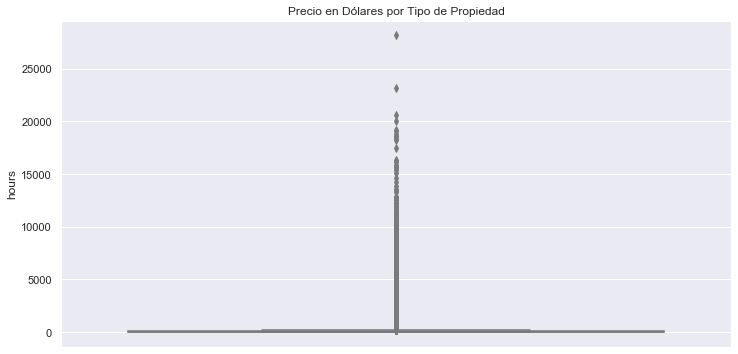

In [24]:
plt.figure(figsize = (12,6))
sns.boxplot(data = df2, y = 'hours', palette= 'pastel')
plt.title('Precio en Dólares por Tipo de Propiedad')
plt.ticklabel_format(axis = 'y', style = 'plain')

In [25]:
mask_hours = (df2['hours'] <= 21000)
df3 = df2[mask_hours]

df3['hours'].describe()

count    776650.000000
mean        111.766781
std         387.844390
min           0.000000
25%           4.000000
50%          15.300000
75%          59.600000
max       20573.300000
Name: hours, dtype: float64

In [26]:
df3

,username,hours,product_id
0,Chaos Syren,0.1,725280
1,Ariman1,13.2,328100
2,freakfantom,0.1,725280
3,The_Cpt_FROGGY,7.8,631920
4,the_maker988,8.2,35140
...,...,...,...
779302,Vidaar,783.5,252490
779303,Nikolai Belinski,55.1,252490
779304,RancorZealot,203.5,252490
779305,Jerry,139.8,252490


In [27]:
df3.dtypes

username       object
hours         float64
product_id      int32
dtype: object

* Si bien Surprise puede trabajar con `username` con Nombre Único, se decide asignarle un Id a cada uno de ellos para que nos sea más fácil hacer las comparaciones en el EDA.

In [28]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df3['username'] = le.fit_transform(df3['username'])
print(df1['username'])

0              Chaos Syren
1                  Ariman1
2              freakfantom
3           The_Cpt_FROGGY
4             the_maker988
                ...       
779302              Vidaar
779303    Nikolai Belinski
779304        RancorZealot
779305               Jerry
779306                Helk
Name: username, Length: 779307, dtype: object


<ipython-input-28-33f375fbccd4>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['username'] = le.fit_transform(df3['username'])


In [29]:
df3.dtypes

username        int32
hours         float64
product_id      int32
dtype: object

In [30]:
df

,Unnamed: 0,username,hours,products,product_id,page_order,date,text,early_access,page,user_id,compensation,found_funny
0,0,Chaos Syren,0.1,41.0,725280,0,2017-12-17,This would not be acceptable as an entertainme...,False,1,NaN,NaN,NaN
1,1,Ariman1,13.2,1386.0,328100,2,2017-08-02,Addictive RPG ! Works fine on linux though it ...,False,1,NaN,NaN,NaN
2,2,freakfantom,0.1,1706.0,725280,5,2017-11-12,Прикольная стрелялка. Взял дешево на распродаже.,False,1,NaN,NaN,NaN
3,3,The_Cpt_FROGGY,7.8,2217.0,631920,0,2017-12-11,Somewhere on Zibylon:\n~~~~~~~~~~~~~~~~~~\nZib...,False,1,7.656120e+16,Product received for free,NaN
4,4,the_maker988,8.2,18.0,35140,7,2018-01-02,"This game was way to linear for me, and compar...",False,1,7.656120e+16,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
779302,779302,Vidaar,783.5,353.0,252490,1,2013-12-11,Summary: Rust is a survival game created by Fa...,True,10217,NaN,NaN,NaN
779303,779303,Nikolai Belinski,55.1,204.0,252490,1,2013-12-11,Coolest Game Eva,True,10218,NaN,NaN,NaN
779304,779304,RancorZealot,203.5,173.0,252490,1,2013-12-11,Should you buy RUST? Uh... YES. The BEST Survi...,True,10219,7.656120e+16,NaN,NaN
779305,779305,Jerry,139.8,79.0,252490,1,2013-12-11,Great game!,True,10220,7.656120e+16,NaN,NaN


In [31]:
df3['ranking'] = pd.qcut(df3.hours, 5, labels=['1', '2', '3', '4', '5'])
print (df3)

        username    hours  product_id ranking
0          62380      0.1      725280       1
1          26824     13.2      328100       3
2         433537      0.1      725280       1
3         347055      7.8      631920       2
4         502628      8.2       35140       2
...          ...      ...         ...     ...
779302    365956    783.5      252490       5
779303    241608     55.1      252490       4
779304    275568    203.5      252490       5
779305    168334    139.8      252490       5
779306    147127  15375.0      252490       5

[776650 rows x 4 columns]


<ipython-input-31-5736bd3af709>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['ranking'] = pd.qcut(df3.hours, 5, labels=['1', '2', '3', '4', '5'])


In [32]:
df3['ranking'].value_counts(normalize=True)

1    0.202744
5    0.199887
4    0.199695
3    0.198839
2    0.198836
Name: ranking, dtype: float64

In [33]:
pd.unique(df3['ranking'])

['1', '3', '2', '4', '5']
Categories (5, object): ['1' < '2' < '3' < '4' < '5']

In [34]:
df4 = df3[['username','ranking','product_id']]
df4

,username,ranking,product_id
0,62380,1,725280
1,26824,3,328100
2,433537,1,725280
3,347055,2,631920
4,502628,2,35140
...,...,...,...
779302,365956,5,252490
779303,241608,4,252490
779304,275568,5,252490
779305,168334,5,252490


In [35]:
df4.dtypes

username         int32
ranking       category
product_id       int32
dtype: object

In [36]:
if True:
    df4.to_csv('final_review.csv', index= False)

DETERMINACIÓN DE RANKING
* Suponemos que si el tiempo de juego de un usuario para 'X' juego, es mayor a 22531.2, la calificación del usuario para 'X' juego es **5**.
* Si el tiempo de juego del usuario se encuentra entre 16898.4 y 22531.2 horas, la calificación se asume como **4**.
* Si el tiempo de juego del usuario se encuentra entre 11265.6 y 16898.4 horas, la calificación se asume como **3**.
* Si el tiempo de juego del usuario se encuentra entre 5632.8 y 11265.6 horas, la calificación se asume como **2**.
* Si el tiempo de juego del usuario se encuentra entre 0 y 5632.8 horas, la calificación se asume como **1**.

DATA GAMES

In [37]:
df_titulo = pd.read_csv('new_data_games.csv', encoding = "ISO-8859-1", usecols = [4,13])
print(df_titulo.shape)
df_titulo.head()

(32135, 2)


,title,id
0,Lost Summoner Kitty,761140.0
1,Ironbound,643980.0
2,Real Pool 3D - Poolians,670290.0
3,å¼¹ç¸äºº2222,767400.0
4,NaN,773570.0


In [38]:
df_titulo = df_titulo[['id','title']]
df_titulo.head()

,id,title
0,761140.0,Lost Summoner Kitty
1,643980.0,Ironbound
2,670290.0,Real Pool 3D - Poolians
3,767400.0,å¼¹ç¸äºº2222
4,773570.0,NaN


In [39]:
df_new = df_titulo.rename(columns={'id':'product_id'})
df_new

,product_id,title
0,761140.0,Lost Summoner Kitty
1,643980.0,Ironbound
2,670290.0,Real Pool 3D - Poolians
3,767400.0,å¼¹ç¸äºº2222
4,773570.0,NaN
...,...,...
32130,773640.0,Colony On Mars
32131,733530.0,LOGistICAL: South Africa
32132,610660.0,Russian Roads
32133,658870.0,EXIT 2 - Directions


In [40]:
df_new.isnull().sum()

product_id       2
title         2050
dtype: int64

In [41]:
df_new_2 = df_new[df_new['product_id'].notna()]

In [42]:
df_new_2

,product_id,title
0,761140.0,Lost Summoner Kitty
1,643980.0,Ironbound
2,670290.0,Real Pool 3D - Poolians
3,767400.0,å¼¹ç¸äºº2222
4,773570.0,NaN
...,...,...
32130,773640.0,Colony On Mars
32131,733530.0,LOGistICAL: South Africa
32132,610660.0,Russian Roads
32133,658870.0,EXIT 2 - Directions


In [43]:
df_new_2.isnull().sum()

product_id       0
title         2049
dtype: int64

In [44]:
print(df_new_2['product_id'])

0        761140.0
1        643980.0
2        670290.0
3        767400.0
4        773570.0
           ...   
32130    773640.0
32131    733530.0
32132    610660.0
32133    658870.0
32134    681550.0
Name: product_id, Length: 32133, dtype: float64


In [45]:
df_new_2[('product_id')] = df_new_2['product_id'].astype(int)

<ipython-input-45-f03820844022>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new_2[('product_id')] = df_new_2['product_id'].astype(int)


In [46]:
print(df_new_2['product_id'])

0        761140
1        643980
2        670290
3        767400
4        773570
          ...  
32130    773640
32131    733530
32132    610660
32133    658870
32134    681550
Name: product_id, Length: 32133, dtype: int32


In [47]:
df_new_2

,product_id,title
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,å¼¹ç¸äºº2222
4,773570,NaN
...,...,...
32130,773640,Colony On Mars
32131,733530,LOGistICAL: South Africa
32132,610660,Russian Roads
32133,658870,EXIT 2 - Directions


In [48]:
df_title = df_new_2.set_index('product_id', drop=True)

In [49]:
df_title

,title
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,å¼¹ç¸äºº2222
773570,NaN
...,...
773640,Colony On Mars
733530,LOGistICAL: South Africa
610660,Russian Roads


In [50]:
df_title.dtypes

title    object
dtype: object

In [51]:
print(df_title.loc[612880])

                                       title
product_id                                  
612880      Wolfenstein II: The New Colossus
612880      Wolfenstein II: The New Colossus


In [52]:
df_title = df_title[~df_title.index.duplicated(keep='first')]

In [53]:
df_title

,title
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,å¼¹ç¸äºº2222
773570,NaN
...,...
773640,Colony On Mars
733530,LOGistICAL: South Africa
610660,Russian Roads


#### 1.3 EXPLORANDO EL DATASET

1. ¿Cuántos usuarios únicos hay?

In [54]:
print(len(df4['username'].unique()))

539030


* 538813 usuarios calificaron juegos.

2. ¿Cuántos juegos únicos hay?

In [55]:
print(len(df_new_2['product_id'].unique())) # Se utiliza df_new_2, porque es donde product_id aún no se encuentra indexado
#len(df_title.product_id.unique())

32132


* Podemos obtener el nombre de una película dado su `Id`.

In [57]:
product_id = 4574
print(df_new_2.loc[product_id])

product_id                                               406590
title         METAL GEAR SOLID V: THE PHANTOM PAIN - Sneakin...
Name: 4574, dtype: object


3. ¿Cuántos juegos calificó cada usuario?

In [60]:
df_by_users = df4.groupby(['username']).count()
# Vemos cuántas calificaciones de películar realizó cada usuario

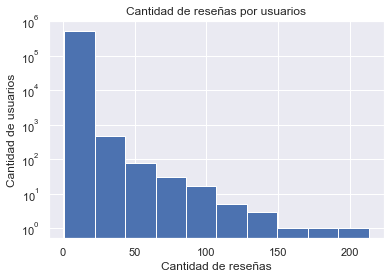

In [61]:
plt.hist(df_by_users.ranking, log= True)

plt.xlabel('Cantidad de reseñas')
plt.ylabel('Cantidad de usuarios')
plt.title('Cantidad de reseñas por usuarios')
plt.show()

* Alrededor del 10% de los usuarios, son los que más calificaciones han dado.

In [64]:
top_ten = df4.sort_values(by='ranking', ascending=False).head(10)
top_ten

,username,ranking,product_id
779306,147127,5,252490
242085,26279,5,332270
667063,449692,5,250560
242106,306395,5,275850
667052,529464,5,222880
667045,434671,5,427520
242142,244256,5,524970
667032,501264,5,563560
242166,107131,5,15100
667013,133152,5,222880


4. ¿Cómo es la distribución de las calificaciones?

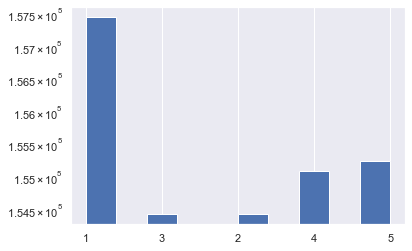

In [65]:
df4['ranking'].hist(log= True)
plt.show()

In [66]:
df4['ranking'].shape

(776650,)

* El mayor número de calificaciones, está alrededor de 1, seguidas de 2.

5. ¿Cómo es la distribución del número de calificaciones por usuario?

In [67]:
calificaciones_por_usuario = df4.username.value_counts() # Vemos por usuario, el conteo de dichas calificaciones
calificaciones_por_usuario # 1er columnas es el ID del usuario, la segunda, la cantidad de calificaciones que dió

# El usuario x hizo x cantidad de calificaciones

5442      213
19123     190
65446     154
240344    142
214778    137
         ... 
120184      1
122233      1
116090      1
128380      1
0           1
Name: username, Length: 539030, dtype: int64

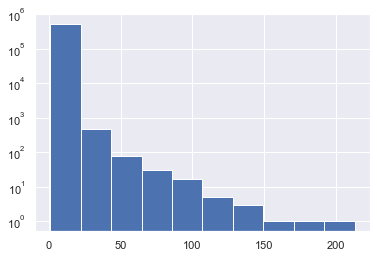

In [68]:
calificaciones_por_usuario.hist(log = True)

* Pocos usuarios realizaron muchas calificaciones (es decir que jugaron más juegos).

6. ¿Cuál es el juego con más calificaciones?¿Cuántas tiene?¿Y la que menos calificaciones tiene?

In [69]:
juegos_por_jugadas = df4.product_id.value_counts() # Hacemos un conteo por película, de los valores únicos por película (para c/ Id de película, cuántos hay)
juegos_por_jugadas.index = df_title.loc[juegos_por_jugadas.index].title # Obtenemos con índice que lo relacionamos con el título, para poder llenar el nombre
juegos_por_jugadas # El juego más jugado es Team Fortress 2

title
Team Fortress 2                                      18372
Rust                                                 10221
Borderlands 2                                         7319
Fallout 4                                             7112
Grand Theft Auto V                                    5975
                                                     ...  
The Perks of Being a Wallflower                          1
CitiesCorp Concept - Build Everything on Your Own        1
Island Racer                                             1
The Frost                                                1
DP Animation Maker                                       1
Name: product_id, Length: 12620, dtype: int64

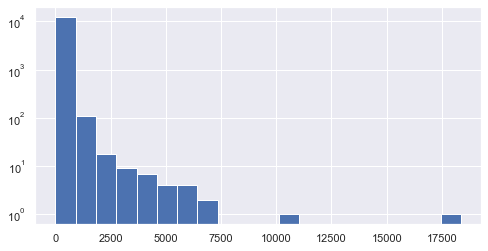

In [70]:
plt.figure(figsize = (8,4))
juegos_por_jugadas.hist(log = True, bins = 20)
plt.show()

* Son pocos los juegos que tienen altas calificaciones.
* Hay bastantes juegos que tienen bajas calificaciones.

#### 1.4 FILTRO COLABORATIVO

### 2. ENTRENAMIENTO

Primero, llevamos el dataset al formato que le gusta a la biblioteca. ¿En qué orden tienen que estar los atributos? Investigar qué hace la clase `Reader` y cuáles son sus parámetros.

In [71]:
df_svd = pd.read_csv('final_review.csv')
print(df_svd.shape)
df_svd.head()

(776650, 3)


,username,ranking,product_id
0,62380,1,725280
1,26824,3,328100
2,433537,1,725280
3,347055,2,631920
4,502628,2,35140


In [72]:
df_svd.dtypes

username      int64
ranking       int64
product_id    int64
dtype: object

In [73]:
reader = Reader() # Para que pueda leer Surprise

Luego, creamos el `Dataset` de Surprise usando `Dataset.load_from_df`

* Un Dataset de Surprise, es muy parecido a un Dataframe de Pandas, sólo que es una estructura que utiliza menos memoria.

In [74]:
N_filas = 100000 # Limitamos el dataset a N_filas

data = Dataset.load_from_df(df_svd[['username','product_id','ranking']][:N_filas], reader) # Decimos cuáles y cuántas filas elegimos
# Cargamos un Dataset, a partir de un Dataframe

In [75]:
trainset, testset = train_test_split(data, test_size=.25) # OJO! Es el de Surprise. Es un Split del Dataset Completo

Vamos a entrenar un algoritmo SVD. Explorar sus parámetros y su funcionamiento.

In [76]:
from surprise import SVD # OJO! Es también es de Surprise!
algo = SVD() # Usamos los hiperparámetros predeterminados

Entrenamos sobre el `trainset`

In [77]:
algo.fit(trainset)

# Entrenamos la Matriz de Utilidad de Train y de Test
# No hay y
# Entrena SVD sobre toda la Matriz de Utilidad (No s/ X e y)

Y predecimos sobre el `testset`. Notar que para predecir sobre un conjunto de test se usa la función `test`.

In [78]:
predictions = algo.test(testset)

Explorar las característica de `predictions` y alguno de sus elementos

In [79]:
predictions[1] # Predicción para 1 (para un usuario en particular)

# uid: Id del Usuario
# iid: Id del juego
# r_ui: calificación que le da a ese juego en particular (la conocida)
# est: estimación de la calificación (obtenida de SVD)
# was imposible = False: fue posible calificar el juego

Prediction(uid=16868, iid=9480, r_ui=3.0, est=3.101914355812637, details={'was_impossible': False})

En cambio, si queremos predecir para un usuario y un juego en particular, usamos la función `predict`

In [80]:
algo.predict(362353, 725280)

Prediction(uid=362353, iid=725280, r_ui=None, est=2.7488130174414156, details={'was_impossible': False})

* r_ui=None: El usuario no la calificó dicho juego.

Exploremos un usuario, veamos cuáles juegos le gustaron y cuáles les recomienda el sistema.

Juegos que le gustaron

In [81]:
usuario = 241609 
rating = 4   # le pedimos los juegos a las haya rankeado con 4 o más
df_user = df_svd[(df_svd['username'] == usuario) & (df_svd['ranking'] >= rating)]
df_user = df_user.reset_index(drop=True)
df_user['title'] = df_title['title'].loc[df_user.product_id].values
df_user

,username,ranking,product_id,title
0,241609,5,440,Team Fortress 2
1,241609,5,440,Team Fortress 2


Creamos donde vamos a guardar las recomendaciones para 1 usuario en particular

In [82]:
recomendaciones_usuario = df_title.iloc[:87339].copy()
print(recomendaciones_usuario.shape)
recomendaciones_usuario.head()

(32132, 1)


,title
product_id,
761140,Lost Summoner Kitty
643980,Ironbound
670290,Real Pool 3D - Poolians
767400,å¼¹ç¸äºº2222
773570,NaN


Sacamos del dataframe todas los juegos que ya sabemos que vio

In [83]:
usuario_vistas = df_svd[df_svd['username'] == usuario]
print(usuario_vistas.shape)
usuario_vistas.head()

(3, 3)


,username,ranking,product_id
382160,241609,5,440
382169,241609,5,440
418321,241609,1,312990


Vemos las recomendaciones que ya podemos hacerle a dicho usuario

In [84]:
recomendaciones_usuario.drop(usuario_vistas.product_id, inplace = True)
recomendaciones_usuario = recomendaciones_usuario.reset_index()
recomendaciones_usuario.head()

,product_id,title
0,761140,Lost Summoner Kitty
1,643980,Ironbound
2,670290,Real Pool 3D - Poolians
3,767400,å¼¹ç¸äºº2222
4,773570,NaN


Y hacemos las recomendaciones, con el Id de película específico, y ordenados de mayor a menor.  
Abajo la Recomendación con su valor.

In [85]:
recomendaciones_usuario['Estimate_Score'] = recomendaciones_usuario['product_id'].apply(lambda x: algo.predict(usuario, x).est)

In [86]:
recomendaciones_usuario = recomendaciones_usuario.sort_values('Estimate_Score', ascending=False)
print(recomendaciones_usuario.head(10))
# Recomendaciones con valuaciones estimadas por debajo

       product_id                                       title  Estimate_Score
387         48700                  Mount &amp; Blade: Warband        4.534299
23229      281990                                   Stellaris        4.446786
28196      314980                      Supreme Ruler Ultimate        4.393409
26952      271590                          Grand Theft Auto V        4.385995
20602      415200                          Motorsport Manager        4.207739
1798       259060           Dominions 4: Thrones of Ascension        4.185662
29201      251060                         Wargame: Red Dragon        4.158174
29069      228180  Action! - Gameplay Recording and Streaming        4.142145
10767      538680  The Legend of Heroes: Trails of Cold Steel        4.073146
4940       342200                       MechWarrior Onlineâ¢        4.055002


### 3. EVALUACIÓN

Para el conjunto de `testset`, evaluamos el error RMSE entre las predicciones y las verdaderas calificaciones que le habían dado a las películas. Para eso, buscar en la documentación cómo se hace.

In [87]:
from surprise import accuracy

accuracy.rmse(predictions)

RMSE: 1.1148


1.1148107494881219

__Nota:__ con `SVD++`, se reducirá aún más el Error.

Después de las recomendaciones de juegos que incluyen calificaciones de juegos, usamos RMSE como evaluaciones de resultados de nuestras recomendaciones. A medida que se amplíe el conjunto de datos, se mejorarán las evaluaciones de RMSE. Lo que significa que nuestras recomendaciones tendrían calificaciones más altas para los usuarios.

### 4. OPTIMIZACIÓN DE PARÁMETROS

**Ejercicio**: hacer un gráfico del desempeño del modelo en función del número de factores del `SVD`.

In [88]:
from surprise.model_selection import cross_validate

rmse_test_means = []
factores = [1,2,4,8,16,32,64,128,256] # Determinamos cuántos valores latentes queremos descubrir

for factor in factores:
    print(f'\nNúmero de Factores: {factor}')
    algo = SVD(n_factors=factor)
    cv = cross_validate(algo, data, measures=['RMSE'], cv = 3, verbose=True)
    rmse_test_means.append(np.mean(cv['test_rmse']))
    
# Va a hacer muchas Ejecuciones, y en c/u de ellas va a ir evaluando los resultados (éste es el proceso manual)


Número de Factores: 1
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.1220  1.1157  1.1192  1.1189  0.0026  
Fit time          2.11    2.15    2.31    2.19    0.09    
Test time         0.56    0.49    0.46    0.50    0.04    

Número de Factores: 2
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.1224  1.1134  1.1235  1.1198  0.0045  
Fit time          2.26    2.16    2.28    2.23    0.05    
Test time         0.45    0.47    0.58    0.50    0.06    

Número de Factores: 4
Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    1.1142  1.1269  1.1199  1.1203  0.0052  
Fit time          2.48    2.22    2.62    2.44    0.17    
Test time         0.58    0.58    0.82    0.66    0.11    

Número de Factores: 8
Evaluating RMSE of algorithm SVD on 3 split(s).

    

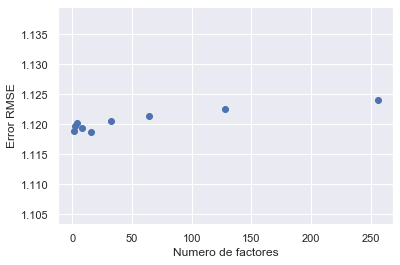

In [89]:
plt.scatter(factores, rmse_test_means)
plt.xlabel('Numero de factores')
plt.ylabel('Error RMSE')
plt.show()